# Домашнее задание по GAN
## 1. Выбор архитектуры

Выбираю NST

## 2. Выбор задачи

Перенести одновременно два стиля на одну картинку контента. Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами.

## 3. Решение задачи



In [1]:
#Импортируем библиотеки
%matplotlib inline
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
#Далее загрузка и подготовка изображений
imsize = 350  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style1_img = image_loader("/content/drive/My Drive/pics/style1.jpg")# as well as here
style2_img = image_loader("/content/drive/My Drive/pics/style2.jpg")
content_img = image_loader("/content/drive/My Drive/pics/content.jpg")#измените путь на тот который у вас.

In [4]:
device

device(type='cuda')

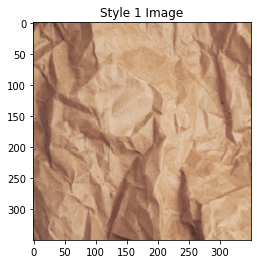

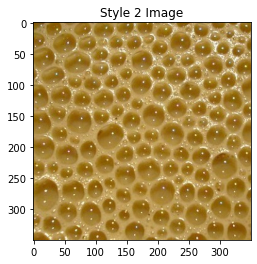

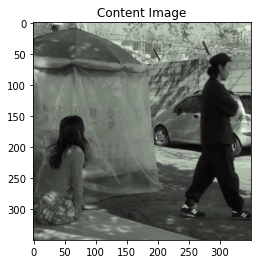

In [5]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# Отрисовка изображений

plt.figure()
imshow(style1_img, title='Style 1 Image')

plt.figure()
imshow(style2_img, title='Style 2 Image')

plt.figure()
imshow(content_img, title='Content Image')


In [6]:

class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

In [7]:

def gram_matrix(input):
        batch_size , f_map_num, h, w = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)
        features = input.reshape(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [8]:
#Так как выбор пал на разделение исходной картинки пополам, то определим Style Loss через соответствующие target feature
#Рассмотрим деление по горизонтальной и вертикальной линиям
class StyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2):
            super(StyleLoss, self).__init__()
            #tg1_size1 = target_feature1.size()[3]/2 #Делим поровну четвертую размерность (по оси x)
            #tg2_size1 = target_feature1.size()[3]/2 #Делим поровну четвертую размерность (по оси x)
            #target_feature1_h = torch.split(target_feature1,int(tg1_size1),3)[0]
            #target_feature2_h = torch.split(target_feature2,int(tg2_size1),3)[1]
            
            tg1_size2 = target_feature1.size()[2]/2 #Делим поровну третью размерность (по оси y)
            tg2_size2 = target_feature2.size()[2]/2 #Делим поровну третью размерность (по оси y)
            
            self.target1 = gram_matrix(torch.split(target_feature1,int(tg1_size2),2)[0]).detach() #Найдем gram_matrix от верхней части
            self.target2 = gram_matrix(torch.split(target_feature2,int(tg2_size2),2)[1]).detach() #Найдем gram_matrix от нижней части
            self.loss = F.mse_loss(self.target1, self.target1)# to initialize with something

        def forward(self, input):
            input_split = torch.split(input,int(input.size()[2]/2),2) #Аналогично для forward
            G1 =  gram_matrix(input_split[0])
            G2 =  gram_matrix(input_split[1])
            loss1 = F.mse_loss(G1, self.target1)
            loss2 = F.mse_loss(G2, self.target2)
            self.loss = loss1 + loss2
            return input

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [10]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [11]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [12]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [13]:

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style1_img, style2_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                #Применим стили по очереди
                target_feature1 = model(style1_img).detach()
                target_feature2 = model(style2_img).detach()
                style_loss = StyleLoss(target_feature1, target_feature2)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)


        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего style loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [14]:

def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [22]:

def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style1_img, style2_img, input_img, num_steps=500,
                        style_weight=200000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style1_img, style2_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        style_history = []
        content_history = []
        loss_history = []
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ошибки
                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                style_history.append(style_score)
                content_history.append(content_score)
                loss_history.append(loss)
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img,style_history, content_history,loss_history

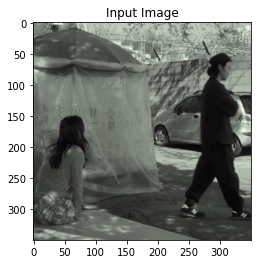

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 97.357391 Content Loss: 10.852442

run [100]:
Style Loss : 31.450029 Content Loss: 12.563805

run [150]:
Style Loss : 14.994567 Content Loss: 12.246074

run [200]:
Style Loss : 9.495985 Content Loss: 11.256374

run [250]:
Style Loss : 7.086401 Content Loss: 10.288767

run [300]:
Style Loss : 5.694663 Content Loss: 9.595118

run [350]:
Style Loss : 4.804480 Content Loss: 9.071256

run [400]:
Style Loss : 4.185941 Content Loss: 8.697543

run [450]:
Style Loss : 3.667146 Content Loss: 8.492671

run [500]:
Style Loss : 3.274337 Content Loss: 8.292303



In [23]:

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output,style_history, content_history,loss_history = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style1_img, style2_img, input_img)

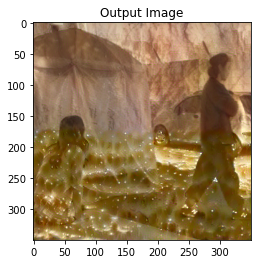

In [24]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [18]:
#Построим графики лоссов чтобы понаблюдать за возможными скачками в лоссах
import numpy as np

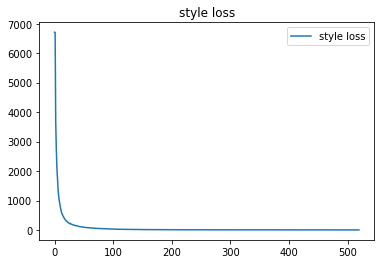

In [25]:
plt.plot(np.arange(len(style_history)), style_history,label='style loss')
plt.title('style loss')
plt.legend(loc='best')
plt.show()

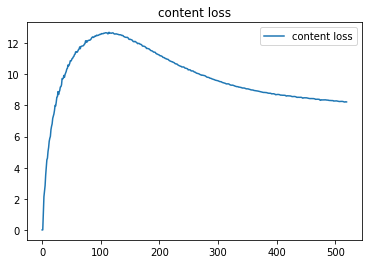

In [26]:
plt.plot(np.arange(len(content_history)), content_history,label='content loss')
plt.title('content loss')
plt.legend(loc='best')
plt.show()

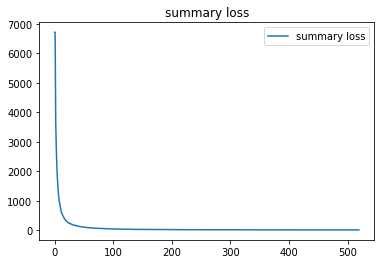

In [27]:
plt.plot(np.arange(len(loss_history)), loss_history,label='summary loss')
plt.title('summary loss')
plt.legend(loc='best')
plt.show()

## Итоги проделанной работы:

1. Удалось реализовать перенос двух стилей, разделенных по горизонтальным и вертикальным осям. (Перенос относительно вертикальной линии закомменчен, отличается лишь порядковым номером размерности).
2. До окончательной реализации был применен меньший формат изображений (resize= 128), при данном размере было очень плохое качество переноса, что может быть связано с недостаточным количеством информации, подаваемой в нейросеть. Увеличение изображения до 350х350 позволило решить проблему.
3. При построении графиков функций потерь не обнаружено значительных скачков, что говорит о стабильности обучения. 